# XGBoost Imbalanced Classification: Microcalcification Classification

### Main techniques used:
* Power Transforms
* XGBoost algorithm (scale_pos_weight = XX)

### Background:
* The Mammography dataset focuses on detecting breast cancer from radiological scans, specifically the presence of clusters of microcalcifications that appear bright on a mammogram.
* Mammograms were scanned, and images were pre-processed to extract objects/features from the mammogram images. It was eventually reduced to 6 features.
* This dataset is quite imbalanced, with about 97.7% majority class and 2.3% minority class.

In [1]:
# import necessary libraries

from collections import Counter

from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from imblearn.metrics import geometric_mean_score
from imblearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier

from xgboost import XGBClassifier
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

### Simple EDA of the data

(937, 50)
Class = 1.0, Count = 41, Percentage = 4.376%
Class = 0.0, Count = 896, Percentage = 95.624%


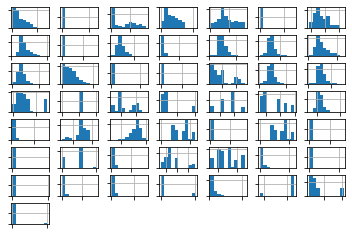

In [2]:
filename = 'oil-spill.csv'
dataframe = read_csv(filename, header=None)
print(dataframe.shape)

target = dataframe.values[:,-1]
counter = Counter(target)
for k, v in counter.items():
    per = v / len(target) * 100
    print(f"Class = {k}, Count = {v}, Percentage = {per:.3f}%")
    
ax = dataframe.hist()
for axis in ax.flatten():
    axis.set_title('')
    axis.set_xticklabels([])
    axis.set_yticklabels([])
pyplot.show()

### Evaluate baseline reference model

In [3]:
# Define a few custom functions

def load_dataset(full_path):
    # load the dataset as a numpy array
    data = read_csv(full_path, header=None)
    # drop unused columns
    data.drop(22, axis=1, inplace=True)
    data.drop(0, axis=1, inplace=True)
    # retrieve numpy array
    data = data.values
    # split into input and output elements
    X, y = data[:, :-1], data[:, -1]
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X, y

# Evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # define the model evaluation the metric
    metric = make_scorer(geometric_mean_score)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

In [4]:
# define the location of the dataset
full_path = 'oil-spill.csv'

# load the dataset
X, y = load_dataset(full_path)

# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))

# define the reference model
model = DummyClassifier(strategy='uniform')

# evaluate the model
scores = evaluate_model(X, y, model)

# summarize performance
# print('Mean G-Mean: %.3f (%.3f)' % (mean(scores), std(scores)))
print(f"Mean G-Mean: {mean(scores):.3f} ({std(scores):.3f}%)")

(937, 47) (937,) Counter({0: 896, 1: 41})
Mean G-Mean: 0.404 (0.207%)


**Note:** This is the baseline reference model, with a lower limit G-mean score of 0.515. We will go on to evaluate XGBoostClassifier to see if it can do better.

### Evaluate XGBClassifier models with and without scale_pos_weights

In [5]:
# Count examples in each class
counter = Counter(y)
# Estimate scale_pos_weight value
estimate = round(counter[0] / counter[1])
print(f"Estimate used in the class-weighted version of XGBoostClassifier(): {estimate:.0f}")

def get_models():
    models, names = list(), list()
    models.append(XGBClassifier())
    names.append('XGB')
    models.append(XGBClassifier(scale_pos_weight=estimate))    
    names.append('XGB_weighted_heuristic')
    models.append(XGBClassifier(scale_pos_weight=100))    
    names.append('XGB_weighted_100')
    return models, names

Estimate used in the class-weighted version of XGBoostClassifier(): 22


In [6]:
full_path = 'oil-spill.csv'
X, y = load_dataset(full_path)

# Define models here
models, names = get_models()

In [7]:
results = list()

# Evaluate each model here
for i in range(len(models)):
    # Pipeline steps defined
    steps = [('p', PowerTransformer()), ('m',models[i])]
    # Pipeline itself defined
    pipeline = Pipeline(steps=steps)
    # Evaluate pipeline and store results
    scores = evaluate_model(X, y, pipeline)
    results.append(scores)
    # Summarize and store results
    print(f"{names[i]}: {mean(scores):.3f} ({std(scores):.3f})")

XGB: 0.437 (0.295)
XGB_weighted_heuristic: 0.576 (0.233)
XGB_weighted_100: 0.583 (0.261)


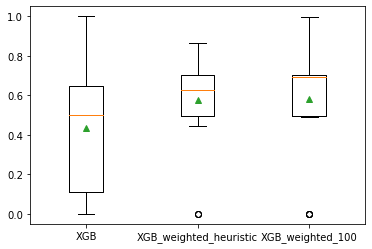

In [8]:
# Visualize above results

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

**Note:** From the results, we can see that across the board, the XGBoostClassifier provides a lift from the baseline model. In addition, specifying a value for the scale_pos_weight parameter helps to scale the error gradient for the positive class. This encourages the model to over-correct them in general.

**Note:** We will go on to perform further data preprocessing and sampling methods to improve the performance.

### Perform Preprocessing + Data Sampling (SMOTE + ENN) 

In [9]:
# Count examples in each class
counter = Counter(y)
# Estimate scale_pos_weight value
estimate = round(counter[0] / counter[1])
print(f"Estimate used in the class-weighted version of XGBoostClassifier(): {estimate:.0f}")
# Define the models that we want to test

def get_models():
    models, names = list(), list()
    # SMOTEENN + Normalization + Power Transform
    
    # Preprocessing + default XGBClassifier
    sampling = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))
    model = XGBClassifier()
    steps = [('t1', MinMaxScaler()), ('t2', PowerTransformer()), ('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('XGB')
    # Preprocessing + XGBClassifier with heuristics weights
    model = XGBClassifier(scale_pos_weight=estimate)
    steps = [('t1', MinMaxScaler()), ('t2', PowerTransformer()), ('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('XGB_weighted_heuristic')
    # Preprocessing + XGBClassifier with greater weights
    model = XGBClassifier(scale_pos_weight=100)
    steps = [('t1', MinMaxScaler()), ('t2', PowerTransformer()), ('e', sampling), ('m', model)]
    models.append(Pipeline(steps=steps))
    names.append('XGB_weighted_100')
    return models, names

Estimate used in the class-weighted version of XGBoostClassifier(): 22


In [10]:
full_path = 'oil-spill.csv'
X, y = load_dataset(full_path)

# Define models here
models, names = get_models()

In [11]:
results = list()

# Evaluate each model here
for i in range(len(models)):
    # Evaluate models and store results
    scores = evaluate_model(X, y, models[i])
    # Summarize and store the scores
    print(f"{names[i]} {mean(scores):.3f} ({std(scores):.3f})")
    results.append(scores)

XGB 0.778 (0.122)
XGB_weighted_heuristic 0.802 (0.127)
XGB_weighted_100 0.838 (0.140)


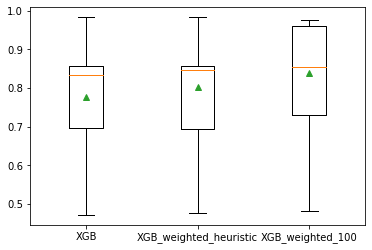

In [12]:
# Visualize above results

pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

**Note:** From the results, we can see that performing some data preprocessing and using SMOTE+ENN to reduce the data imbalanced has helpd improve the performance of the XGBoostClassifier algorithm. Similarly, XGBClassifiers provided with a value for the scale_pos_weight hyperparameter did better.